### To Investigate
It's common knowledge that people often flee colder places and travel to Arizona during the cooler months of the year.  Using the **Citations** dataset, published by the Scottsdale Police Department, I wanted to understand the impact of seasonal visitors during cooler points in the year.  Often these visitors are retired and own a second home in Arizona.  As a result, many of them spend an extended amount of time in Scottsdale when they visit.


1. Do the ages of people getting citations at different points in the year reflect these seasonal visitors?  
1. Do these seasonal visitors have a disproportionate impact on specific citation types?
1. For citations that are more highly impacted by seasonality: 
    - Does mean age analysis of the day of week provide further evidence supporting point 2 above?
    - Does mean age analysis of the time of day provide further evidence supporting point 2 above?

### Data Source
On a weekly basis the City of Scottsdale Police Department publishes a [dataset](http://data.scottsdaleaz.gov/dataset/police-citations)* which includes the prior years citations.  These citations are largely made up of vehicle related infractions such as speeding.  I downloaded the data in September of 2018, as well as September 2019 - providing two years worth of citations data.  In raw format the combined dataset includes just over 48.5K rows and 22 columns.  For privacy issues, the City of Scottsdale does not release citation data for anyone under 18.  

<br/>

*Contains information from the City of Scottsdale Open Database Portal, which is made available here under the [Open Database License](http://www.scottsdaleaz.gov/AssetFactory.aspx?did=69351).


### Method
1. Find the mean age of the top 20 citation types for each month of the year.
1. Find the variance within the months of the year for each citation type.
1. Identify the top 5 citations with the highest variance throughout the year.
1. For each of the above 5 citations graph the mean age across the year. Do the citation patterns seem to agree with each other?
1. Graph the same 5 citations based on day of the week, and hour of the day.  Do the citation patterns seem to agree with each other?

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob

In [3]:
# read in csv files
files = glob.glob('data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [4]:
citations.head()

,Arizona Statute Code,Beat,Charge Description,Citation #,Citation Date,Citation Time,Citation Type Code,Citation Type Description,Cited Person,Cited Person Age,...,Cited Person Sex,City,District,Officer Badge #,State,Street,Street Number,Zip,Zone,tcmainid
0,13-1203A1,2.0,Assault-Intentional/Recklessly Injure,2065379,06/23/2018,204,CR,Criminal,"Hill, Julie",25,...,F,Scottsdale,D1,1489,AZ,N Granite Reef Rd,1xxx,NaN,412,621784
1,13-3415A,3.0,Drug Paraphernalia-Possess/Use,2065378,06/23/2018,48,CR,Criminal,"Mysliwiec, Michael",35,...,M,Scottsdale,D1,1489,AZ,N 70th St / E McDowell Rd,xxx,NaN,405,621787
2,13-1203A1,2.0,Assault-Intentional/Recklessly Injure,2059893,06/23/2018,203,CR,Criminal,"Miranda, Javier",24,...,M,Scottsdale,D1,1462,AZ,N Granite Reef Rd,1xxx,NaN,412,621792
3,28-3473A,6.0,Suspended/Revoked D.L.,2058884,06/23/2018,40,CT,Criminal Traffic,"Harrison, Stevia",31,...,F,Scottsdale,D2,1466,AZ,E Indian School Rd,7xxx,NaN,906,621794
4,28-2322,12.0,Expired Out-Of-State Reg,2060841,06/23/2018,933,CV,Civil Traffic,"Cagape, Catherine",36,...,F,Scottsdale,D3,1504,AZ,E Shea Bl,8xxx,NaN,3006,621796


### Preprocess Data

In [6]:
# convert column labels to lower case and remove spaces from column names
def setcols(df, fn=lambda x: x.columns.map('_'.join), cols=None):
    if cols:
        df.columns = cols
    else:
        df.columns = fn(df)
    return df

citations = citations.pipe(
        setcols,
        fn=lambda x: x.columns.str.lower()
        .str.strip()
        .str.replace(" ", "_"))

In [7]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])

# create month column
citations['month'] = citations['citation_date'].dt.month

# create year column
citations['year'] = citations['citation_date'].dt.year

# create day of week column
citations['day_of_week'] = citations['citation_date'].dt.dayofweek

# extract the hour of the day from the citation time column
citations['hour_of_day'] = citations['citation_time'].apply(lambda x: str(x)[-4:-2])

# replace blanks with 0
# this happened for citations that took place during the hour of 12am
citations.loc[citations.hour_of_day == '', 'hour_of_day'] = 0

# change data type of hour from object to number
citations.hour_of_day = pd.to_numeric(citations.hour_of_day)

# change data type of age from object to number
citations.cited_person_age = pd.to_numeric(citations.cited_person_age, errors='coerce')

In [8]:
# how many rows and columns are in the dataset?
citations.shape

(48607, 26)

In [16]:
citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,...,street,street_number,zip,zone,tcmainid,year_month,month,year,day_of_week,hour_of_day
0,97XX,12.0,Amended Charge,2074492,2018-12-20,2222,CV,Civil Traffic,"Way, Dennis",51.0,...,E Sahuaro DR / N Scottsdale Rd,xxx,NaN,3003,641301,2018.12,12,2018,Thursday,22
1,28-701A,10.0,Speed Greater Than R&P or Posted,8093305,2018-12-20,844,CV,Civil Traffic,"Grady, Scott",61.0,...,N Scottsdale Rd,8xxx,NaN,2601,641302,2018.12,12,2018,Thursday,8
2,28-4135C,3.0,No Proof of Insurance,2076259,2018-12-18,2147,CV,Civil Traffic,"Dudgeon, Miranda",20.0,...,E Osborn Rd / N Scottsdale Rd,xxx,NaN,706,641303,2018.12,12,2018,Tuesday,21
3,28-2532A,5.0,Expired/No Arizona Registration,8093703,2018-12-21,2116,CV,Civil Traffic,"Fox, William",34.0,...,E Chaparral Rd / N Hayden Rd,xxx,NaN,1106,641304,2018.12,12,2018,Friday,21
4,28-4135C,15.0,No Proof of Insurance,2053182,2018-12-20,2324,CV,Civil Traffic,"Rhoden, David",24.0,...,E Frank Lloyd Wright Bl / N Hayden Rd,xxx,NaN,3604,641305,2018.12,12,2018,Thursday,23


### Dataset Overview

In [9]:
# how many unique citations are in the dataset?
citations.charge_description.value_counts().shape

(395,)

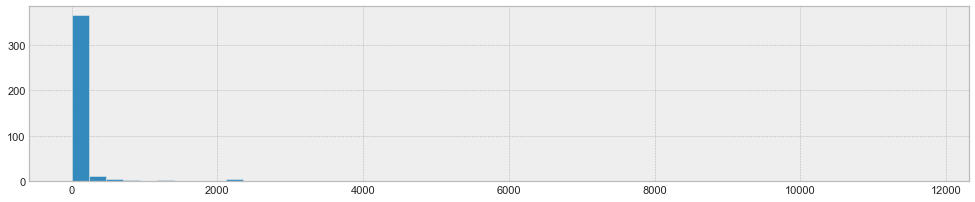

In [69]:
# examine a histogram of the counts of citations associated with each citation type
# there are a huge number of citations that are only used a few times each year
plt.figure(figsize=(15,3))
plt.style.use('bmh')
citations.charge_description.value_counts().hist(bins=50)

Text(0.5, 0, 'Cited Person Age')

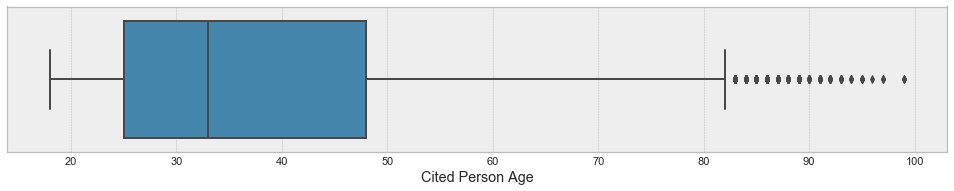

In [68]:
# box plot showing the age distribution of people who receive a citation
plt.figure(figsize=(15,2.5))
sns.boxplot(x=citations.cited_person_age)
plt.xlabel('Cited Person Age')

Text(0.5, 0, 'Cited Person Age')

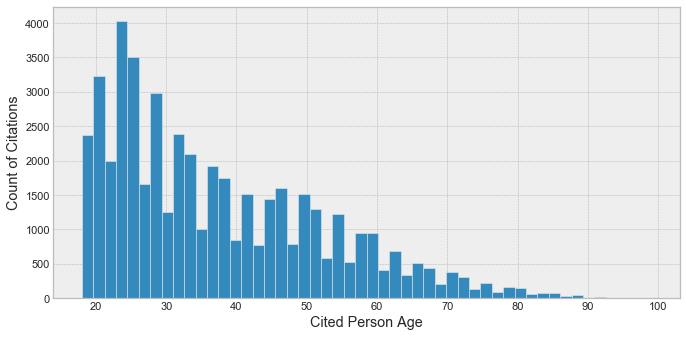

In [67]:
# examine a histogram of the ages of people who received citations
plt.figure(figsize=(10,5))
citations.cited_person_age.hist(bins=50)
plt.ylabel('Count of Citations')
plt.xlabel('Cited Person Age')

### The distribution of age appears to be closer to chi-squared than normal, with a long tail

In [16]:
# since I will be averaging age for my analysis
# I want to make sure the citations I am analyzing have a reasonable number of 
# I'm going to select the top 20 citations by count, almost all of these are traffic related
citations.charge_description.value_counts()[0:20]

Speed Greater Than R&P or Posted                 11725
Expired/No Arizona Registration                   3972
Suspended/Revoked D.L.                            3001
DUI-Impaired to Slightest Degree                  2272
Failure to Control Speed to Avoid A Collision     2269
No Proof of Insurance                             2244
Drug Paraphernalia-Possess/Use                    2174
Fail to Obey Traffic Control Device               1622
Fail to Stop at Stop Sign                         1348
Fail to Stop For Red Signal                       1310
Exceed Limit By More Than 20mph                   1053
Exceed 15mph In School Crossing                    846
Urinate/Defecate In Public                         778
Void Charge                                        732
Shoplifting-Removal of Goods                       559
Fail to Yield Turning Left at Intersection         553
Display M.I. Suspended Plate                       533
Unsafe Lane Change                                 513
Expired Ou

In [17]:
# by unique citation, what percent do my 20 citations make up?
round(citations.charge_description.value_counts()[0:20].shape[0]/citations.charge_description.value_counts().shape[0], 3)

0.051

In [18]:
# by count of citations, what percent of total citations do the top 20 make up?
round(citations.charge_description.value_counts()[0:20].sum() / citations.charge_description.count(), 3)

0.788

In [19]:
# subset full citation dataset with only the top 20 citations by count
top20_citations = citations[citations.charge_description.isin(citations.charge_description.value_counts()[0:20].index)]

In [20]:
top20_citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,...,state,street,street_number,zip,zone,tcmainid,month,year,day_of_week,hour_of_day
1,13-3415A,3.0,Drug Paraphernalia-Possess/Use,2065378,2018-06-23,48,CR,Criminal,"Mysliwiec, Michael",35.0,...,AZ,N 70th St / E McDowell Rd,xxx,NaN,405,621787,6,2018,5,0
3,28-3473A,6.0,Suspended/Revoked D.L.,2058884,2018-06-23,40,CT,Criminal Traffic,"Harrison, Stevia",31.0,...,AZ,E Indian School Rd,7xxx,NaN,906,621794,6,2018,5,0
5,13-3415A,10.0,Drug Paraphernalia-Possess/Use,2063172,2018-06-23,928,CR,Criminal,"Mc Cuan, Michael",51.0,...,AZ,N Hayden Rd,7xxx,NaN,2504,621797,6,2018,5,9
7,28-3473A,12.0,Suspended/Revoked D.L.,1939725,2018-06-23,849,CT,Criminal Traffic,"Montano, Mark",32.0,...,AZ,N 68th Pl / E Cactus Rd,xxx,85254,3104,621801,6,2018,5,8
8,28-1381A1,18.0,DUI-Impaired to Slightest Degree,2065679,2018-06-23,1023,CT,Criminal Traffic,"White, Candice",45.0,...,AZ,L101 / N Pima Rd,xxx,NaN,3802,621804,6,2018,5,10


Text(0.5, 0, 'Month of Year')

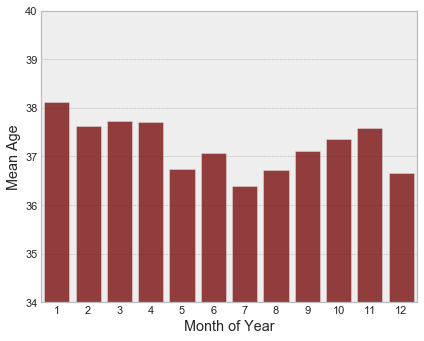

In [82]:
# what is the distribution of mean ages throughout the year?
plt.figure(figsize=(6,5))

sns.barplot(x=top20_citations.groupby(top20_citations.month)['cited_person_age'].mean().index,
           y=top20_citations.groupby(top20_citations.month)['cited_person_age'].mean().values,
           color='darkred',
           alpha=.8)
plt.ylim(34, 40)
plt.ylabel('Mean Age')
plt.xlabel('Month of Year')

#### YEARLY AGE DISTRIBUTION
Looking at the bar chart, we can see that the hotter months of the year are associated with a decline in the mean age of people receiving citations.  This seems to fit with our hypothesis that older people seasonally visit the area more during the cooler months of the year.  In the next section I will perform more granular analysis on the mean age distributions of specific citations, and how they track accross the year.

## T-TEST ANALYSIS

Ho = there is no difference between the mean age of people who receive citations during the coldest months of the year and the rest of the year
Ha = there is a difference between the mean age of people who receive citations during the coldest months of the year and the rest of the year

But my p-values below are quite large, which means I can't reject the null hypothesis, right?

### COLD MONTHS vs. ALL MONTHS

In [124]:
# months of the year when I expect the most seasonal visitors
cold_months = [11, 12, 1, 2]

In [129]:
# subset citation data for only the months I expect the most visitors
cold_months_citations = top20_citations[top20_citations.month.isin(cold_months)]

In [134]:
cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean().unstack().head()

month,1,2,11,12
charge_description,,,,
DUI-Impaired to Slightest Degree,35.707447,35.487013,34.763006,32.492126
Disorderly Conduct-Disruptive Behavior,35.916667,30.977273,32.517241,28.081081
Display M.I. Suspended Plate,32.325581,35.777778,32.740000,33.342857
Drug Paraphernalia-Possess/Use,29.347826,29.193717,29.908602,29.775862
Exceed 15mph In School Crossing,43.548077,42.103448,43.699029,38.615385


In [138]:
# find the mean age for top 20 citations for only the coldest months
cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean())

charge_description
DUI-Impaired to Slightest Degree                 34.612398
Disorderly Conduct-Disruptive Behavior           31.873065
Display M.I. Suspended Plate                     33.546554
Drug Paraphernalia-Possess/Use                   29.556502
Exceed 15mph In School Crossing                  41.991485
Exceed Limit By More Than 20mph                  32.738803
Expired Out-Of-State Registration                34.656062
Expired/No Arizona Registration                  37.383955
Fail to Obey Traffic Control Device              42.008491
Fail to Stop For Red Signal                      40.630912
Fail to Stop at Stop Sign                        41.090056
Fail to Yield Turning Left at Intersection       47.220238
Failure to Control Speed to Avoid A Collision    42.233483
No Proof of Insurance                            36.531688
Shoplifting-Removal of Goods                     33.429756
Speed Greater Than R&P or Posted                 38.336667
Suspended/Revoked D.L.               

In [141]:
# find the mean age for top 20 citations for the whole year
top20_citations.groupby(top20_citations.charge_description)['cited_person_age'].mean()

charge_description
DUI-Impaired to Slightest Degree                 34.317782
Disorderly Conduct-Disruptive Behavior           32.431217
Display M.I. Suspended Plate                     35.484053
Drug Paraphernalia-Possess/Use                   29.992640
Exceed 15mph In School Crossing                  41.457447
Exceed Limit By More Than 20mph                  33.425451
Expired Out-Of-State Registration                34.945274
Expired/No Arizona Registration                  37.165156
Fail to Obey Traffic Control Device              41.429100
Fail to Stop For Red Signal                      41.246565
Fail to Stop at Stop Sign                        39.977745
Fail to Yield Turning Left at Intersection       46.226040
Failure to Control Speed to Avoid A Collision    40.778316
No Proof of Insurance                            36.537433
Shoplifting-Removal of Goods                     33.973166
Speed Greater Than R&P or Posted                 38.344563
Suspended/Revoked D.L.               

In [142]:
# t-test comparison of the above

ttest_ind(
    cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()),
      
    top20_citations.groupby(top20_citations.charge_description)['cited_person_age'].mean()
    )

Ttest_indResult(statistic=0.10557659720740409, pvalue=0.9164736471636691)

### HOT MONTHS vs COLD MONTHS T-TEST

In [143]:
# months of the year when I expect the least seasonal visitors
hot_months = [6, 7, 8, 9]

In [145]:
# subset citation data for only the months I expect the most visitors
hot_months_citations = top20_citations[top20_citations.month.isin(hot_months)]

In [146]:
hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean().unstack().head()

month,6,7,8,9
charge_description,,,,
DUI-Impaired to Slightest Degree,33.622449,33.941176,33.513228,34.325581
Disorderly Conduct-Disruptive Behavior,31.052632,31.114286,34.266667,30.777778
Display M.I. Suspended Plate,38.054054,38.000000,34.428571,38.588235
Drug Paraphernalia-Possess/Use,29.964467,30.016393,32.688742,29.822222
Exceed 15mph In School Crossing,NaN,NaN,38.934066,41.327273


In [148]:
# find the mean age for top 20 citations for only the coldest months
hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean())

charge_description
DUI-Impaired to Slightest Degree                 33.850609
Disorderly Conduct-Disruptive Behavior           31.802840
Display M.I. Suspended Plate                     37.267715
Drug Paraphernalia-Possess/Use                   30.622956
Exceed 15mph In School Crossing                  40.130669
Exceed Limit By More Than 20mph                  33.733824
Expired Out-Of-State Registration                35.231422
Expired/No Arizona Registration                  36.909434
Fail to Obey Traffic Control Device              41.207148
Fail to Stop For Red Signal                      40.886552
Fail to Stop at Stop Sign                        38.763312
Fail to Yield Turning Left at Intersection       47.763721
Failure to Control Speed to Avoid A Collision    38.862284
No Proof of Insurance                            35.273453
Shoplifting-Removal of Goods                     34.363399
Speed Greater Than R&P or Posted                 38.055536
Suspended/Revoked D.L.               

In [149]:
# t-test comparison of the above

ttest_ind(
    cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()),
      
    hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean())
    )

Ttest_indResult(statistic=0.2778308728135038, pvalue=0.7826482650340848)

## MONTH OF THE YEAR AND AGE ANALYSIS

In [22]:
# mean age for top 20 citations at each month of the year
top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().head()

charge_description,DUI-Impaired to Slightest Degree,Disorderly Conduct-Disruptive Behavior,Display M.I. Suspended Plate,Drug Paraphernalia-Possess/Use,Exceed 15mph In School Crossing,Exceed Limit By More Than 20mph,Expired Out-Of-State Registration,Expired/No Arizona Registration,Fail to Obey Traffic Control Device,Fail to Stop For Red Signal,Fail to Stop at Stop Sign,Fail to Yield Turning Left at Intersection,Failure to Control Speed to Avoid A Collision,No Proof of Insurance,Shoplifting-Removal of Goods,Speed Greater Than R&P or Posted,Suspended/Revoked D.L.,Unsafe Lane Change,Urinate/Defecate In Public,Void Charge
month,,,,,,,,,,,,,,,,,,,,
1,35.707447,35.916667,32.325581,29.347826,43.548077,34.203704,34.823529,36.895442,41.344828,40.018692,44.776471,43.000000,43.662551,37.637255,33.230769,38.721065,34.561947,48.583333,27.833333,37.492754
2,35.487013,30.977273,35.777778,29.193717,42.103448,33.467532,34.069767,38.296820,42.927273,38.820225,41.741573,54.380952,40.538835,37.375000,33.062500,38.590012,34.679426,49.617021,29.446429,37.015625
3,35.436893,35.617647,35.021739,29.727749,41.526316,32.125000,34.357143,38.337386,42.224806,43.166667,39.915094,46.811321,42.476415,37.753623,35.607843,38.608216,33.781132,44.800000,28.512500,36.591549
4,35.052632,30.815789,33.378378,30.864865,41.955224,34.045455,36.939394,37.294985,41.181102,42.664000,36.963415,46.155172,40.157609,38.403315,34.040000,39.082019,34.954545,45.333333,28.876923,39.979167
5,33.157407,33.791667,36.808511,29.716578,41.966667,32.666667,34.558824,36.545732,40.831933,40.930435,40.579439,40.238095,39.619792,35.820755,33.000000,38.251009,34.325000,43.545455,27.682927,35.958333


In [23]:
# top 5 citations with the highest variability throughout the year
top20_citations.groupby([top20_citations.charge_description, top20_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.var()).sort_values(ascending=False).head(5)

charge_description
Fail to Yield Turning Left at Intersection    20.204360
Fail to Stop For Red Signal                    6.901291
Disorderly Conduct-Disruptive Behavior         5.556823
Unsafe Lane Change                             5.542446
Display M.I. Suspended Plate                   5.237240
Name: cited_person_age, dtype: float64

In [24]:
# subset full citation dataset with only the top 5 highly variable citations by age
top5_variance = citations[citations.charge_description.isin(
    top20_citations.groupby([top20_citations.charge_description, top20_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.var()).sort_values(ascending=False).head(5).index)]

In [25]:
top5_variance.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,...,state,street,street_number,zip,zone,tcmainid,month,year,day_of_week,hour_of_day
11,28-729.1,15.0,Unsafe Lane Change,2060049,2018-06-22,915,CV,Civil Traffic,"JOhns, Mary",78.0,...,AZ,E Frank Lloyd Wright Bl / N Greenway-Hayden Loop,xxx,NaN,3602,621810,6,2018,4,9
13,28-4139A,12.0,Display M.I. Suspended Plate,2056701,2018-06-23,1412,CV,Civil Traffic,"Paltiel, Sasson",63.0,...,AZ,E Cactus Rd / N Scottsdale Rd,xxx,85254,3104,621815,6,2018,5,14
28,28-772,1.0,Fail to Yield Turning Left at Intersection,2065877,2018-06-22,2119,CV,Civil Traffic,"Mosqueda, Javier",21.0,...,AZ,N Hayden Rd / E Roosevelt St,xxx,NaN,305,621850,6,2018,4,21
31,28-4139A,NaN,Display M.I. Suspended Plate,2061965,2018-06-24,35,CV,Civil Traffic,"Anderson, Jenna",32.0,...,AZ,L101 Frontage Rd Sb,1xxx,NaN,0,621854,6,2018,6,0
32,28-4139A,20.0,Display M.I. Suspended Plate,2064963,2018-06-23,2209,CV,Civil Traffic,"Pinney, Eric",37.0,...,AZ,N 56th St / E Dynamite Bl,xxx,NaN,4201,621857,6,2018,5,22


In [26]:
# organize top 5 highly variable citations to be able to graph
top5_variance.groupby([top5_variance.month, top5_variance.charge_description])['cited_person_age'].mean().reset_index().head()

,month,charge_description,cited_person_age
0,1,Disorderly Conduct-Disruptive Behavior,35.916667
1,1,Display M.I. Suspended Plate,32.325581
2,1,Fail to Stop For Red Signal,40.018692
3,1,Fail to Yield Turning Left at Intersection,43.000000
4,1,Unsafe Lane Change,48.583333


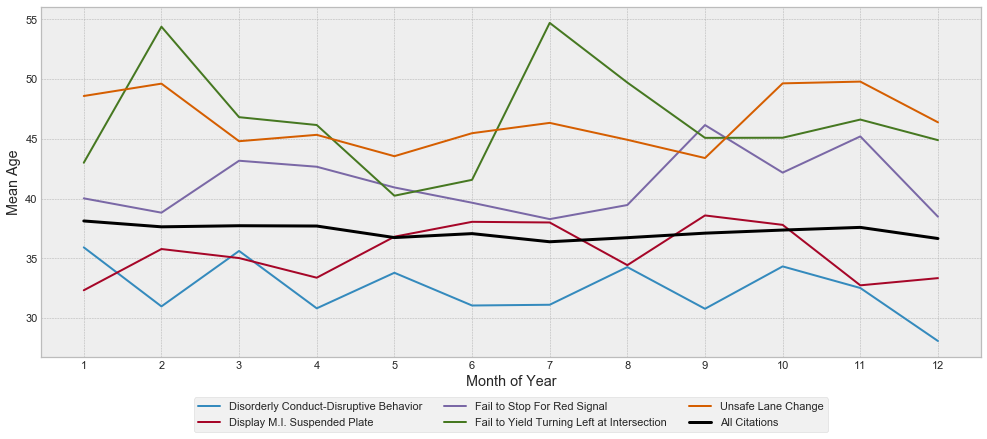

In [64]:
# graph the mean age of citations with highest variance throughout the year
sns.set(rc={'figure.figsize':(15,6)})
sns.set(rc={"lines.linewidth":2})
plt.style.use('bmh')

ax = sns.lineplot(y=top5_variance.groupby([top5_variance.month, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,2],
            x=top5_variance.groupby([top5_variance.month, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,0],
            hue=top5_variance.groupby([top5_variance.month, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,1])

# graph mean age of all citations in bold
x = top20_citations.groupby([top20_citations.month]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,0]

y1 = top20_citations.groupby([top20_citations.month]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,1]

plt.plot(x, y1, color='black',linewidth=3)

plt.ylabel('Mean Age')
plt.xlabel('Month of Year')

ax.xaxis.set_major_locator(ticker.MultipleLocator())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

### MAX - your oppinion, I wanted to bold the two lines for the two citations I feel communicate the most information.  However I wasn't able to figure out how to do that with seaborn(above).  I used just matplotlib below.  Which would you recommend that I use?

#### TOP 5 CITATIONS BY AGE VARIANCE DISTRIBUTION

By examination, only two of the above 5 citations(Fail to Yield Turing Left at Intersection, and Unsafe Lane Change) graphed across the year seem to indicate seasonality in older visitors to Scottsdale.  The other three citations show a high variance throughout the year, however they don't show a strong seasonal pattern throughout the year.

## DAY OF THE WEEK AND AGE ANALYSIS

In [298]:
# groupby day of the week and charge description
top5_variance.groupby([top5_variance.day_of_week, top5_variance.charge_description])['cited_person_age'].mean().unstack().head()

charge_description,Disorderly Conduct-Disruptive Behavior,Display M.I. Suspended Plate,Fail to Stop For Red Signal,Fail to Yield Turning Left at Intersection,Unsafe Lane Change
day_of_week,,,,,
0,32.891304,36.356322,42.214724,46.169231,42.640625
1,39.433333,33.783133,42.617347,45.065421,49.794521
2,38.347826,35.860465,40.375000,47.270588,47.282609
3,35.903226,34.602740,42.613065,47.636364,48.255556
4,33.166667,34.945946,38.888350,46.972222,46.778947


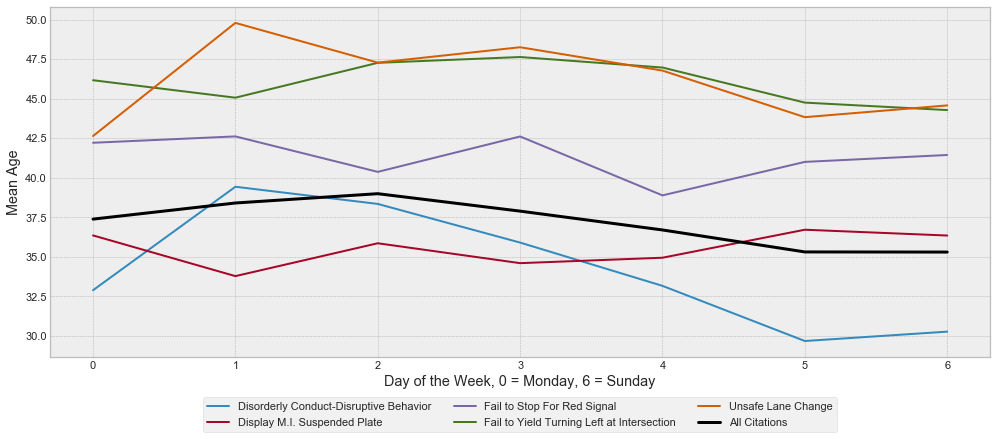

In [62]:
# graph the mean age of citations with highest variance throughout the week
sns.set(rc={'figure.figsize':(15,6)})
sns.set(rc={"lines.linewidth":2})
plt.style.use('bmh')

ax = sns.lineplot(y=top5_variance.groupby([top5_variance.day_of_week, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,2],
            x=top5_variance.groupby([top5_variance.day_of_week, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,0],
            hue=top5_variance.groupby([top5_variance.day_of_week, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,1])

x = top20_citations.groupby(
    [top20_citations.day_of_week]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,0]
y1 = top20_citations.groupby(
    [top20_citations.day_of_week]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,1]

plt.plot(x, y1, color='black',linewidth=3)

plt.ylabel('Mean Age')
plt.xlabel('Day of the Week, 0 = Monday, 6 = Sunday')

ax.xaxis.set_major_locator(ticker.MultipleLocator())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

#### ANALYSIS: TOP 5 CITATIONS BY AGE VARIANCE - WEEKLY DISTRIBUTION

By examination, three of the above 5 citations(Fail to Yield Turing Left at Intersection, Unsafe Lane Change, and Disorderly Conduct-Disruptive Behavior) graphed across the week show similar patterns.  The weekend citations are dominated by younger people, while older people more frequently receive these citations during the normal days of the week.

The other two citations(Display MI Suspended Plate, and Fail to Stop for Red Signal) don't describe any particular weekly pattern.

## TIME OF DAY AND MEAN AGE ANALYSIS

In [296]:
# groupby hour of day and charge description
top5_variance.groupby([top5_variance.hour_of_day, top5_variance.charge_description])['cited_person_age'].mean().unstack().head()

charge_description,Disorderly Conduct-Disruptive Behavior,Display M.I. Suspended Plate,Fail to Stop For Red Signal,Fail to Yield Turning Left at Intersection,Unsafe Lane Change
hour_of_day,,,,,
0,27.179487,33.131579,33.546667,32.0,28.0
1,27.750000,32.608696,30.552632,51.0,38.0
2,27.277778,34.250000,31.857143,32.0,30.0
3,27.666667,39.333333,37.900000,72.0,NaN
4,28.600000,35.750000,39.300000,61.0,NaN


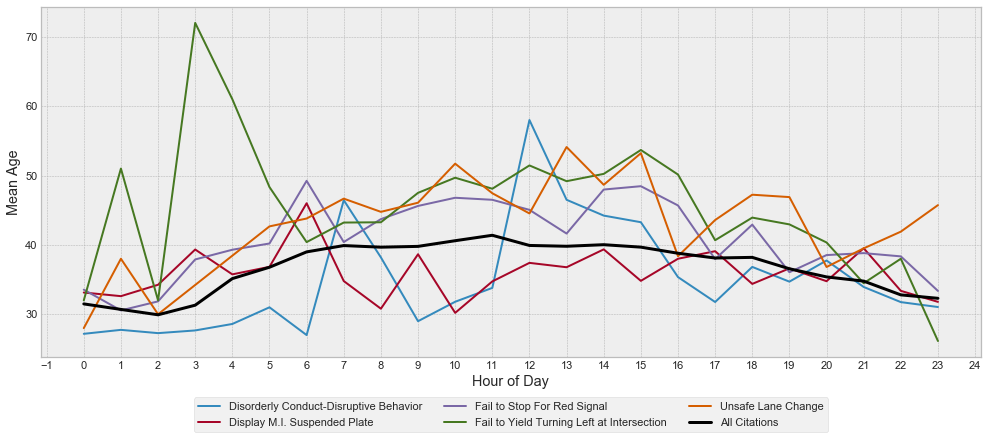

In [60]:
# graph the mean age of citations with highest variance throughout the year
sns.set(rc={'figure.figsize':(15,6)})
sns.set(rc={"lines.linewidth":2})
plt.style.use('bmh')
ax = sns.lineplot(y=top5_variance.groupby([top5_variance.hour_of_day, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,2],
            x=top5_variance.groupby([top5_variance.hour_of_day, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,0],
            hue=top5_variance.groupby([top5_variance.hour_of_day, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,1])

x = top20_citations.groupby(
    [top20_citations.hour_of_day]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,0]
y1 = top20_citations.groupby(
    [top20_citations.hour_of_day]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,1]

plt.plot(x, y1, color='black',linewidth=3)

plt.ylabel('Mean Age')
plt.xlabel('Hour of Day')

ax.xaxis.set_major_locator(ticker.MultipleLocator())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

#### TOP 5 CITATIONS BY AGE VARIANCE - TIME OF DAY DISTRIBUTION

The above graph shows a lot more noise than the previous graphs.  This is because the data is bucketed in a more granular level(24 buckets) representing each hour of the day.  As a result, there are fewer data points within each hour, causing the mean value to be tugged more dramatically.  This is especially true for the citation "Fail to Yield Turning Left at Intersection" at 3AM - the mean age is over 70.  Likely, one person over 70 was the only person to receive that citation during that hour of the day, causing the mean to be so dramatically high.

With the exception of citations "Disorderly Conduct-Disruptive Behavior" and "Display M.I. Suspended Plate", the middle of the day(between 8am and 4pm) show the largest amount of separation from the mean age distribution across the whole day.  This indicates that these citations are more heavily weighted towards older people which likely will not be on the roads at very late and early times of the day.

### T-Test
#### Since the data doesn't appear to be a normal distribution, and for month of the year I only have 12 data points, I don't believe the t-test is appropriate.

#### 'Fail to Yield Turning Left at Intersection'

In [85]:
# mean age for 'Fail to Yield Turning Left at Intersection' citations
top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Yield Turning Left at Intersection']

month
1     43.000000
2     54.380952
3     46.811321
4     46.155172
5     40.238095
6     41.567568
7     54.700000
8     49.707317
9     45.080000
10    45.090909
11    46.611111
12    44.888889
Name: Fail to Yield Turning Left at Intersection, dtype: float64

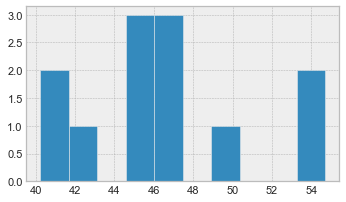

In [98]:
plt.figure(figsize=(5,3))

top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Yield Turning Left at Intersection'].hist()

In [88]:
# mean age for all citations at each month of the year
citations.groupby(
    [citations.month]) \
    ['cited_person_age'].mean()

month
1     38.173091
2     37.762428
3     37.507459
4     37.765862
5     37.184005
6     36.886102
7     36.530944
8     36.967017
9     37.447397
10    37.485994
11    37.649494
12    36.815321
Name: cited_person_age, dtype: float64

In [90]:
from scipy.stats import ttest_ind

ttest_ind(top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Yield Turning Left at Intersection'],
      
    citations.groupby(
    [citations.month]) \
    ['cited_person_age'].mean()
         
         )

Ttest_indResult(statistic=7.028515995203373, pvalue=4.7206776697281174e-07)

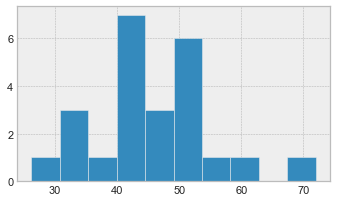

In [109]:
# hour of the day
plt.figure(figsize=(5,3))

top20_citations.groupby(
    [top20_citations.hour_of_day, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Yield Turning Left at Intersection'].hist()

In [110]:
ttest_ind(top20_citations.groupby(
    [top20_citations.hour_of_day, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Yield Turning Left at Intersection'],
      
    citations.groupby(
    [citations.hour_of_day]) \
    ['cited_person_age'].mean()
         
         )

Ttest_indResult(statistic=3.943341091867838, pvalue=0.0002719599186059298)

#### 'Unsafe Lane Change'

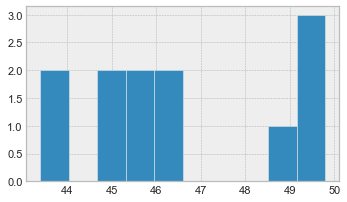

In [99]:
plt.figure(figsize=(5,3))
top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Unsafe Lane Change'].hist()

In [91]:
from scipy.stats import ttest_ind

ttest_ind(
    top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Unsafe Lane Change'],
      
    citations.groupby(
    [citations.month]) \
    ['cited_person_age'].mean()
       
    )

Ttest_indResult(statistic=13.17437247736258, pvalue=6.485035169519392e-12)

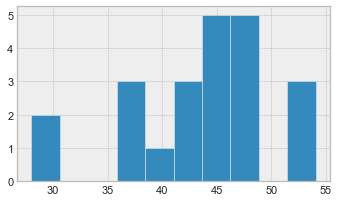

In [115]:
plt.figure(figsize=(5,3))
top20_citations.groupby(
    [top20_citations.hour_of_day, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Unsafe Lane Change'].hist()

In [116]:
# this throws an error because there are NaN values
ttest_ind(
    top20_citations.groupby(
    [top20_citations.hour_of_day, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Unsafe Lane Change'],
      
    citations.groupby(
    [citations.hour_of_day]) \
    ['cited_person_age'].mean()
       
    )

C:\Users\mrkjh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\mrkjh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\mrkjh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Ttest_indResult(statistic=nan, pvalue=nan)

#### 'Fail to Stop For Red Signal'

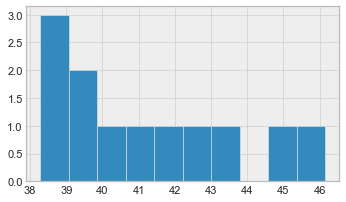

In [100]:
plt.figure(figsize=(5,3))
top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Stop For Red Signal'].hist()

In [108]:
ttest_ind(
    top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Stop For Red Signal'],
      
    citations.groupby(
    [citations.month]) \
    ['cited_person_age'].mean()
       
    )

Ttest_indResult(statistic=5.062773985245665, pvalue=4.5260691025056516e-05)

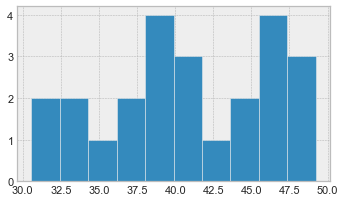

In [123]:
plt.figure(figsize=(5,3))
top20_citations.groupby(
    [top20_citations.hour_of_day, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Stop For Red Signal'].hist()

In [121]:
ttest_ind(
    top20_citations.groupby(
    [top20_citations.hour_of_day, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().loc[:,'Fail to Stop For Red Signal'],
      
    citations.groupby(
    [citations.hour_of_day]) \
    ['cited_person_age'].mean()
       
    )

Ttest_indResult(statistic=2.857506142948357, pvalue=0.00639228177835697)

## CONCLUSIONS
There are several citations that are more frequently issued to older people, and thus should show a higher frequency during the cooler months of the year when more older visitors are in Scottsdale AZ.  Specifically "Fail to Yield Turning Left at Intersection" and "Unsafe Lane Change".  To a lesser extent "Fail to Stop for Red Signal" also is received by older people more frequently, however it doesn't show a pattern of seasonality similar to the other two.  On the other hand "Disorderly Conduct-Disruptive Behavior" and "Display M.I. Suspended Plate" show a high amount of age variation, but the variation does not show a pattern of seasonality.

Being able to predict the mean age groups that are more likely to receive certain citations, as well as the times of year when higher numbers of certain age groups are in Scottsdale can allow the Scottsdale Police Department to more effectively police the city.  For [law firms](https://www.phoenixlawteam.com/blog/left-hand-turn/) that frequently represent clients who have been involved in an accident due to "Fail to Yield Turning Left at Intersection", knowing when more older people are on the streets, and that they are more susceptible to receive this citation may allow them to more accurately target advertisement of their services. 

#### FURTHER CONSIDERATIONS:
1. If I were to obtain more data, say 10 years worth, would I see these same trends continue?
1. On the other end of the spectrum from older visitors more generally during winter months, is there citation evidence of specific pockets of younger visitors?(spring break)